<a href="https://colab.research.google.com/github/irfanbykara/Machine-Learning-Notebooks/blob/main/Tiny_Vgg_Versus_EfficientNet_Pretrained_on_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

torch.__version__



'1.13.1+cu116'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import requests
import zipfile
from pathlib import Path

# # Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi data...


In [ ]:
import os

def walk_through_dir(dir_path):
  for dir_path, dir_names, file_names in os.walk(dir_path):
    print(f"Directory path {dir_path} includes directories {dir_names} and files {file_names}")

In [ ]:
walk_through_dir(data_path)

Directory path data includes directories ['pizza_steak_sushi_20_percent'] and files ['pizza_steak_sushi_20_percent.zip']
Directory path data/pizza_steak_sushi_20_percent includes directories ['train', 'test'] and files []
Directory path data/pizza_steak_sushi_20_percent/train includes directories ['steak', 'sushi', 'pizza'] and files []
Directory path data/pizza_steak_sushi_20_percent/train/steak includes directories [] and files ['2013535.jpg', '3476564.jpg', '1761285.jpg', '1816235.jpg', '40094.jpg', '714298.jpg', '239025.jpg', '2748917.jpg', '819027.jpg', '3074367.jpg', '2403776.jpg', '167069.jpg', '3465327.jpg', '2159975.jpg', '405173.jpg', '2716993.jpg', '165639.jpg', '3807440.jpg', '2400975.jpg', '2254705.jpg', '75537.jpg', '3113772.jpg', '1961025.jpg', '359330.jpg', '1839481.jpg', '2606444.jpg', '2966859.jpg', '1212161.jpg', '2628106.jpg', '2761427.jpg', '1849463.jpg', '1598345.jpg', '1937872.jpg', '3777482.jpg', '2614189.jpg', '141056.jpg', '1334054.jpg', '2324994.jpg', '292864

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

steak height:512 width: 382


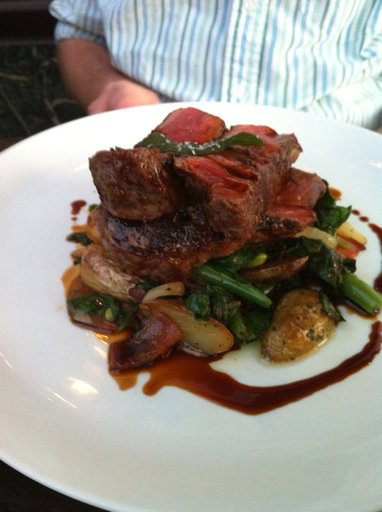

In [ ]:
import random
from PIL import Image
import matplotlib.pyplot as plt
all_images_paths = list(image_path.glob("*/*/*.jpg"))

sample_image = random.choice(all_images_paths)

img = Image.open(sample_image)
img_class = sample_image.parent.stem
print(sample_image.parent.stem,"height:"+ str(img.height)+" width: "+ str(img.width))
img

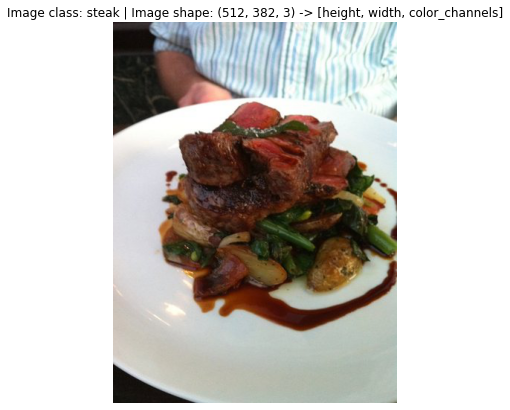

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {img_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [ ]:
data_transform_train = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),

    transforms.ToTensor()
])
data_transform_test = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ToTensor()
])

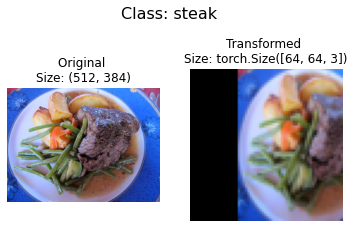

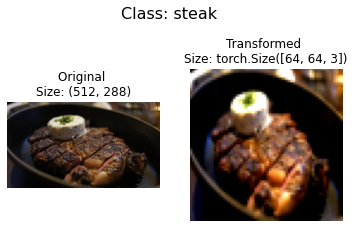

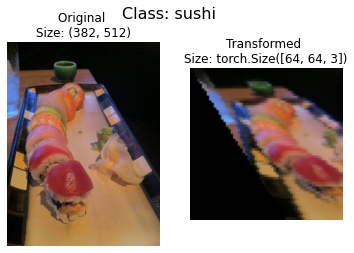

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(all_images_paths,
                        transform=data_transform_train,
                        n=3)


In [ ]:
train_data = datasets.ImageFolder(
    root = train_dir,
    transform = data_transform_train,
    target_transform = None
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = data_transform_test,
)

In [ ]:
print(f"Train data \n : {train_data}, test data : \n {test_data}")

Train data 
 : Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi_20_percent/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           ), test data : 
 Dataset ImageFolder
    Number of datapoints: 150
    Root location: data/pizza_steak_sushi_20_percent/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict


{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(train_data), len(test_data)


(450, 150)

In [ ]:
train_data[0][0].shape # This is image tensor


torch.Size([3, 64, 64])

In [ ]:
idx = train_data[0][1] # this is label
key_list = list(class_dict.keys())
val_list = list(class_dict.values())

position = val_list.index(idx)
print(key_list[position])



pizza


Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


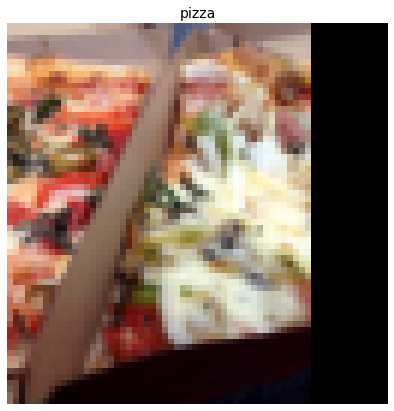

In [ ]:
img, label = train_data[10][0], train_data[10][1]

img_permuted = img.permute(1,2,0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permuted.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);


In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=os.cpu_count(),
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7fc9fd6508e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc9fd6506d0>)

In [ ]:
len(train_dataloader),len(test_dataloader)

(15, 150)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [ ]:
# 1. Take in a Dataset as well as a list of class names
from typing import List
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)


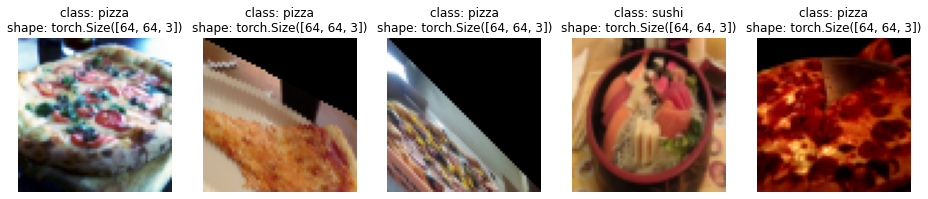

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)


In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


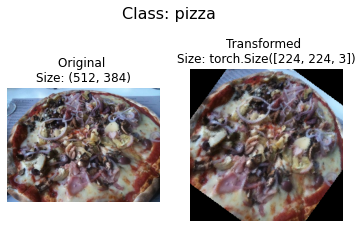

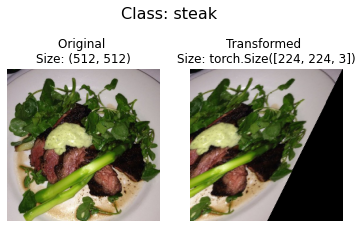

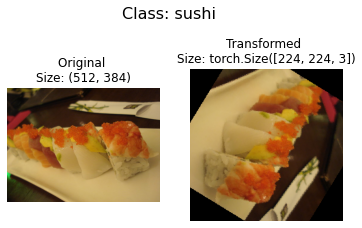

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)


In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=hidden_units*16)
            ,
            nn.Linear(in_features=hidden_units*16,
                      out_features=output_shape),

        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=30,
                  output_shape=len(train_data.classes)).to(device)
model_0


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=7680, out_features=480, bias=True)
    (2): Linear(in_features=480, out_features=3, bias=True)
  )
)

In [ ]:
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")


Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[-0.0334, -0.0127,  0.0179]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3254, 0.3322, 0.3425]], device='cuda:0')

Output prediction label:
tensor([2], device='cuda:0')

Actual label:
1


In [ ]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size


In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=30,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

In [ ]:
model_0_results.keys()


In [ ]:
from typing import Dict
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();



In [ ]:
plot_loss_curves(model_0_results)



```
# ToDo: Try to predict a never seen image.
```



** Try to predict a new image with a new model, state of art efficient net. **

In [ ]:
!pip install efficientnet_pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet
effnetb4 = EfficientNet.from_pretrained('efficientnet-b4')


In [ ]:
EfficientNet.get_image_size('efficientnet-b4')
x = torch.rand((2,3,380,380))

features = effnetb4.extract_features(x)
features.shape


In [ ]:
effnetb4._fc.in_features


In [ ]:
class EffNetCNN(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()

        # 선학습 모델에서는 특징 추출 부분만 사용하고
        # (N,3,380,280)->(N,1792,12,12)
        self.features = backbone

        # (N,1792,12,12)->(N,1792,1,1)
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.classifier = torch.nn.Sequential(
            ##############################################
            # WRITE YOUR CODE HERE
            # 여기서 self.features가 출력하는 모양을 flatten 했을 때
            # 노드 수를 계산하여
            # 계산된 노드수->100으로 가는 완전 연결층을 구성하기
            torch.nn.Linear(backbone._fc.in_features, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(1024, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(512, 3),
            torch.nn.LogSoftmax(dim=-1)
            ##############################################
        )

    def forward(self, x):
        self.fmap = self.features.extract_features(x) # (N,3,300,300)->(N,1920,9,9)

        N = self.fmap.shape[0]
        x = self.avg_pool(self.fmap).reshape(N,-1) # (N,1920,9,9)->(N,1920,1,1)->(N,1920)
        x = self.classifier(x) #(N,1920)->(N,100)

        return x


In [ ]:
model = EffNetCNN(effnetb4)


In [ ]:
lr =  0.0001 # 학습률
epochs = 30  # 에폭수

criterion = torch.nn.NLLLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=lr, weight_decay=0.015)


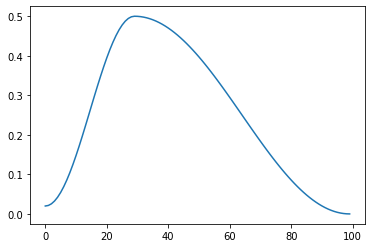

In [ ]:
model_test = torch.nn.Linear(2, 1)
optimizer_ = torch.optim.SGD(model_test.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer_, max_lr=0.5,
                                                steps_per_epoch=10,
                                                epochs=10)
lrs = []
for i in range(100): # steps_per_epoch*epochs
    optimizer_.step()
    # 옵티마이저가 한 스탭 진행하고 그 때 사용한 학습률을 리스트에 저장
    lrs.append(optimizer_.param_groups[0]["lr"])

    # 스케쥴러 스탭을 실행해서 학습률을 업데이트
    scheduler.step()

# 학습을 마치고 학습률의 변화를 그려봄
plt.plot(lrs)
plt.show()


In [ ]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.0007,
    steps_per_epoch=2*len(train_dataloader),
    epochs=20)


In [ ]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [ ]:
beta = 1.0
cutmix_prob = 0.5


In [ ]:
torch.cuda.empty_cache()

In [ ]:
data_transform_train = transforms.Compose([
    transforms.Resize(size=(380,380)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),

    transforms.ToTensor()
])
data_transform_test = transforms.Compose([
    transforms.Resize(size=(380,380)),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ToTensor()
])

In [ ]:
train_data = datasets.ImageFolder(
    root = train_dir,
    transform = data_transform_train,
    target_transform = None
)

test_data = datasets.ImageFolder(
    root = test_dir,
    transform = data_transform_test,
)

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=8, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             num_workers=os.cpu_count(),
                                              batch_size=1,

                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7fc9f053fa60>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc9f053f580>)

In [ ]:
%%time
from  tqdm import tqdm

torch.cuda.empty_cache()

model.to(device)

running_losses = []
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []
for e in range(20):
    running_loss = 0.0
    train_acc = 0.0

    model.train()
    corr = 0

    tqdm_stream_train = tqdm(train_dataloader)
    # tqdm_stream_test = tqdm(test_dataloader)

    for i, d in enumerate(tqdm_stream_train):
        X_batched = d[0]
        y_batched = d[1] #type(torch.float32)

        X_batched = X_batched.to(device) #cuda()
        y_batched = y_batched.to(device) # (N,), torch.int64

        optimizer.zero_grad()
  # CUT-MIX: https://arxiv.org/abs/1905.04899
        r = np.random.rand(1)
        if beta > 0 and r < cutmix_prob:
            lam = np.random.beta(beta, beta)
            rand_idx = torch.randperm(X_batched.shape[0]).to(device)
            target_a = y_batched
            target_b = y_batched[rand_idx]
            bbx1, bby1, bbx2, bby2 = rand_bbox(X_batched.size(), lam)
            X_batched[:, :, bbx1:bbx2, bby1:bby2] = X_batched[rand_idx, :, bbx1:bbx2, bby1:bby2]
            lam = 1 - ( (bbx2-bbx1)*(bby2-bby1) / (X_batched.shape[-1]*X_batched.shape[-2]) )

            y_pred = model(X_batched)

            loss = criterion(y_pred, target_a) * lam + criterion(y_pred, target_b)*(1.-lam)
        ##################################################
        else:
            y_pred = model(X_batched) #.squeeze() #(N,1)->(N,), torch.float32
            loss = criterion(y_pred, y_batched) #(N,100), (N,)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        corr += (torch.argmax(y_pred,dim=-1) == y_batched).sum()

        tqdm_stream_train.set_description(f"Trainning Epoch{e+1:3d}")

        scheduler.step()


    running_loss = running_loss / len(train_dataloader)
    running_losses.append(running_loss)
    train_acc = corr / len(train_data)
    # train_loss_list.append(running_loss)
    # train_acc_list.append(train_acc)

    print(f"RESULT Epoch{e+1:3d}, Train Loss:{running_loss:.6f}, Train Acc.:{train_acc:.6f}") #, Valid Acc.:{val_acc:.6f}")


Trainning Epoch  1: 100%|██████████| 57/57 [00:25<00:00,  2.20it/s]


RESULT Epoch  1, Train Loss:0.492898, Train Acc.:0.857778


Trainning Epoch  2: 100%|██████████| 57/57 [00:26<00:00,  2.15it/s]


RESULT Epoch  2, Train Loss:0.526737, Train Acc.:0.831111


Trainning Epoch  3: 100%|██████████| 57/57 [00:26<00:00,  2.15it/s]


RESULT Epoch  3, Train Loss:0.491862, Train Acc.:0.791111


Trainning Epoch  4: 100%|██████████| 57/57 [00:25<00:00,  2.20it/s]


RESULT Epoch  4, Train Loss:0.508069, Train Acc.:0.855556


Trainning Epoch  5: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


RESULT Epoch  5, Train Loss:0.573046, Train Acc.:0.815556


Trainning Epoch  6: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch  6, Train Loss:0.447853, Train Acc.:0.851111


Trainning Epoch  7: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch  7, Train Loss:0.395468, Train Acc.:0.877778


Trainning Epoch  8: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch  8, Train Loss:0.541393, Train Acc.:0.795556


Trainning Epoch  9: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch  9, Train Loss:0.508034, Train Acc.:0.846667


Trainning Epoch 10: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


RESULT Epoch 10, Train Loss:0.580403, Train Acc.:0.806667


Trainning Epoch 11: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch 11, Train Loss:0.613310, Train Acc.:0.780000


Trainning Epoch 12: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch 12, Train Loss:0.669973, Train Acc.:0.755556


Trainning Epoch 13: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch 13, Train Loss:0.535690, Train Acc.:0.791111


Trainning Epoch 14: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


RESULT Epoch 14, Train Loss:0.563142, Train Acc.:0.820000


Trainning Epoch 15: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch 15, Train Loss:0.493043, Train Acc.:0.842222


Trainning Epoch 16: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch 16, Train Loss:0.462904, Train Acc.:0.848889


Trainning Epoch 17: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


RESULT Epoch 17, Train Loss:0.527995, Train Acc.:0.815556


Trainning Epoch 18: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]


RESULT Epoch 18, Train Loss:0.610890, Train Acc.:0.751111


Trainning Epoch 19: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


RESULT Epoch 19, Train Loss:0.471973, Train Acc.:0.860000


Trainning Epoch 20: 100%|██████████| 57/57 [00:26<00:00,  2.19it/s]

RESULT Epoch 20, Train Loss:0.409657, Train Acc.:0.911111
CPU times: user 5min 18s, sys: 3min 10s, total: 8min 28s
Wall time: 8min 42s


In [ ]:
model.eval()
test_loss = 0.0
test_acc = 0.0

with torch.inference_mode():
# Loop through DataLoader batches
  for batch, (X, y) in enumerate(test_dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate loss
      loss = criterion(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

# Adjust metrics to get average loss and accuracy per batch
test_loss = test_loss / len(test_dataloader)
test_acc = test_acc / len(test_dataloader)
print(test_loss,test_acc)

0.20218694989879926 0.9666666666666667


In [ ]:
torch.save(model.state_dict(), "effnet_food")

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_1.pth


In [ ]:
model

EffNetCNN(
  (features): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddin

In [ ]:
# Load in custom image and convert the tensor values to float32
import torchvision
custom_image = torchvision.io.read_image(str("steak2.jpg")).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.


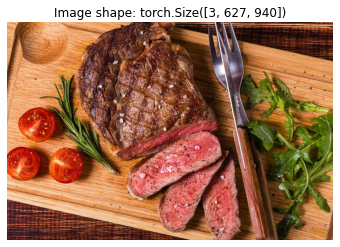

In [ ]:
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);


In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize((380, 380)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")


Original shape: torch.Size([3, 627, 940])
New shape: torch.Size([3, 380, 380])


In [ ]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 380, 380])
Unsqueezed custom image shape: torch.Size([1, 3, 380, 380])


In [ ]:
custom_image_pred

tensor([[-3.2550, -0.1253, -2.5362]], device='cuda:0')

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")



Prediction logits: tensor([[-3.2550, -0.1253, -2.5362]], device='cuda:0')
Prediction probabilities: tensor([[0.0386, 0.8823, 0.0792]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


In [ ]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class


'steak'

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [ ]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=16):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([3, 380, 380])
Test sample label: 0 (pizza)


In [ ]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]


tensor([[0.9011, 0.0672, 0.0316],
        [0.0410, 0.9170, 0.0420]])

In [ ]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes


tensor([0, 1, 0, 1, 1, 1, 0, 2, 2, 0, 1, 0, 2, 1, 1, 2])

In [ ]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes


([0, 1, 0, 1, 1, 1, 0, 2, 2, 0, 1, 0, 2, 1, 1, 2],
 tensor([0, 1, 0, 1, 1, 1, 0, 2, 2, 0, 1, 0, 2, 1, 1, 2]))

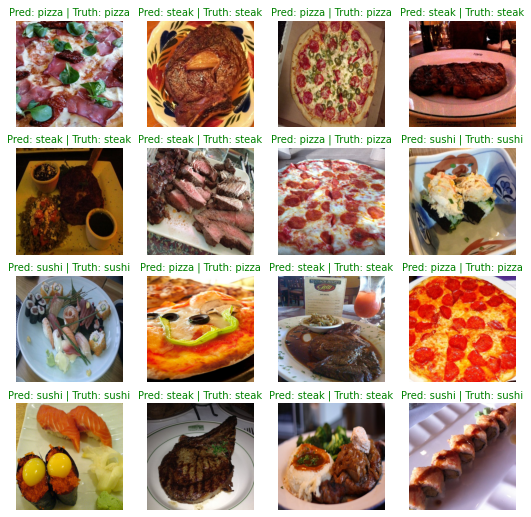

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 4
ncols = 4
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);


In [ ]:
test_images = []
test_labels = []
for sample, label in list(test_data):
    test_images.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_images[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")


Test sample image shape: torch.Size([3, 380, 380])
Test sample label: 0 (pizza)


In [ ]:
len(test_data)

150

In [ ]:
pred_probs= make_predictions(model=model,
                             data=test_images)


In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        1, 2, 2, 2, 2, 2])

In [ ]:
wrong_preds_class = []
x = 0
for i  in range(len(pred_classes)):
  if pred_classes[i] != test_labels[i]:
    print(pred_classes[i])
    if pred_classes[i] not in wrong_preds_class:
      wrong_preds_class.append(pred_classes[i])
    x+=1
len(wrong_preds_class)


tensor(0)
tensor(2)
tensor(1)
tensor(1)


3

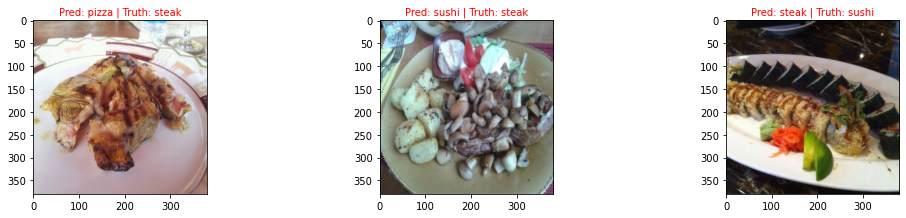

In [ ]:
# Plot predictions
plt.figure(figsize=(30, 30))
nrows = 8
ncols = 5
iter = 0
pred_labels = []
for i, sample in enumerate(test_images):
  # Create a subplot
  # Check for equality and change title colour accordingly
  pred_label = class_names[pred_classes[i]]

    # Get the truth CLASSES (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  if pred_label == truth_label:
    pass
  else:
    if iter<40 and (pred_label not in pred_labels):
      pred_labels.append(pred_label)
      plt.subplot(nrows, ncols, iter+1)

      # Plot the target image
      plt.imshow(sample.permute(1,2,0), cmap="gray")

      # Find the prediction label (in text form, e.g. "Sandal")

      # Create the title text of the plot
      title_text = f"Pred: {pred_label} | Truth: {truth_label}"


      plt.title(title_text, fontsize=10, c="r") # red text if wrong
      iter += 1
  plt.axis(True);
